In [69]:
# basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hour, day, MW, kg, megatonnes, lb, kWh, MWh
import sys

# osier imports
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize


# set the solver based on operating system -- assumes glpk or cbc is installed.
if "win32" in sys.platform:
    solver = 'glpk'
elif "linux" in sys.platform:
    solver = "appsi_highs"
else:
    solver = "appsi_highs"

print(f"Solver set: {solver}")

Solver set: appsi_highs


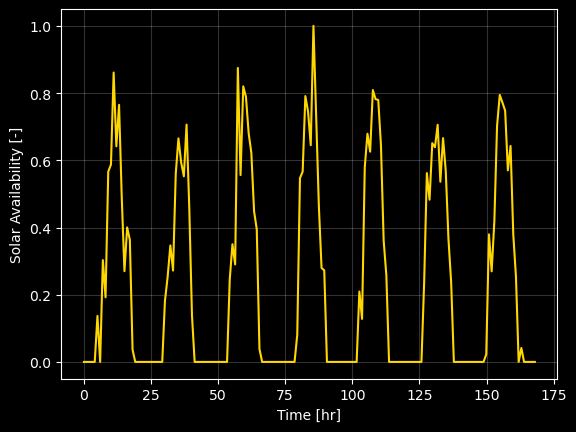

In [37]:
n_hours = 24  # hours per day
n_days = 7  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = np.pi/2  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)

solar = (-np.sin((hours*np.pi/n_hours*2+phase_shift)))
# solar[solar<0] = 0

rng = np.random.default_rng(1234)

solar += rng.normal(size=N)*15e-2
solar[solar<0] = 0

solar = solar/solar.max()  # rescale


with plt.style.context("dark_background"):
    plt.plot(hours, solar, color='gold')
    plt.ylabel('Solar Availability [-]')
    plt.xlabel('Time [hr]')
    plt.grid(alpha=0.2)
    plt.show()

In [35]:
peak_demand = 1e3*MW 
demand = np.ones(N)*peak_demand

In [38]:
natural_gas = lib.natural_gas
natural_gas_adv = lib.natural_gas_adv
nuclear_ap1000 = lib.nuclear
nuclear_smr = lib.nuclear_adv
solar = lib.solar
battery = lib.battery

In [ ]:
solar.capital_cost = 1432.009/kW
solar.eroi = 
solar.

unyt_quantity(0.6732, '1/MW')

In [64]:
emission_df = pd.read_html("https://www.eia.gov/tools/faqs/faq.php?id=74&t=11")[0].droplevel(1, axis=1).set_index('Unnamed: 0_level_0').iloc[:-1,:-2]
emission_df.columns = ['Total kWh', 'Total CO2 million mt', 'million short tons','lbs per kWh']
emission_df.index.name = ''
emission_df

,Total kWh,Total CO2 million mt,million short tons,lbs per kWh
,,,,
Coal,675115,709,781,2.31
Natural gas,1806063,790,871,0.96
Petroleum,16233,18,20,2.46
All other energy sources,4183271,1532,1688,0.81


In [42]:
solar.co2_rate

unyt_quantity(0., 'megatonnes/(MW*hr)')

In [83]:
eroi_df = pd.read_csv("../../../data/eroi_data.csv", index_col=0)
eroi_df

,EROIstd
Generation method,
Natural Gas (CCGT),89.0
Natural Gas (CCGT & CCS),12.4
"Solar PV (Mono-Si, SE-med)",2.5
Nuclear (83% centrifuge),69.6
Nuclear (100% centrifuge),96.2


In [84]:
# for a NG 1-on-1 H Frame design
natural_gas.co2_rate = (float(emission_df.at['Natural gas', 'lbs per kWh'])*lb/kWh).to(megatonnes/MWh)
natural_gas.capital_cost = 1727.696 / kW
natural_gas.om_cost_variable = 2.49 / MWh
natural_gas.om_cost_fixed = 39 / kW
natural_gas.eroi = eroi_df.at['Natural Gas (CCGT)', 'EROIstd'] # from Walmsley et al.
# same design, with 95% CCS
natural_gas_adv.co2_rate = natural_gas.co2_rate * 0.05
natural_gas_adv.capital_cost = 3268.514 / kW
natural_gas_adv.om_cost_variable = 5.1 / MWh
natural_gas_adv.om_cost_fixed = 74.4 / kW
natural_gas_adv.eroi = eroi_df.at['Natural Gas (CCGT & CCS)', 'EROIstd'] # from Walmsley et al.

In [86]:
solar.om_cost_variable

unyt_quantity(0., '1/(MW*hr)')

In [88]:
# utility scale solar, with good insolation, middling estimate
solar.capital_cost = 1491.641/kW
solar.eroi = eroi_df.at['Solar PV (Mono-Si, SE-med)', 'EROIstd'] # from Walmsley et al. 2018
solar.om_cost_fixed = 21.001/kW

In [90]:
battery.capital_cost = 1711.403 / kW
battery.om_cost_fixed = 38.777 / kW
battery.eroi = 10  # actually an 'ESOI,' from Barnhart and Benson 2013

In [ ]:
nuclear_ap1000.capital_cost = 7616.359 / kW
nuclear_ap1000.om_cost_fixed = 175 / kW
nuclear_ap1000.om_cost_variable = 
nuclear_ap1000.eroi = eroi_df.at['Nuclear (100% centrifuge)', 'EROIstd']

nuclear_smr.capital_cost = 
nuclear_smr.om_cost_fixed = 136 / kW
nuclear_smr.om_cost_variable = 2.8 / MWh
nuclear_smr.eroi = eroi_df.at['Nuclear (100% centrifuge)', 'EROIstd']